In [2]:
from utils import *

# DECISION TREE

In [13]:
df, train, test, val = get_data(normalize=False, binary_label=True)

In [4]:
from collections import Counter


class DecisionTreeClassifier:

    def __init__(self, max_depth=float('inf')):
        self.max_depth = max_depth
        self.root = None

    def fit(self, x, y):
        assert len(x) == len(y)
        assert len(x) != 0
        self.root = self._create_tree(x, y, None, self.max_depth)

    def _create_tree(self, data, labels, parent, max_depth):
        new_node = Node(None, None, parent)
        if not len(data):
            new_node.label = parent.label  # Use parent label
            return new_node
        most_common_result = Counter(labels).most_common(1)[0][0]
        if len(labels) == 1 or data.shape[1] == 0:  # No more features to split
            new_node.label = most_common_result
            return new_node
        if len(np.unique(labels)) == 1:  # All labels are the same
            new_node.label = labels[0]
            return new_node

        best_feature, best_threshold = self._find_best_split(data, labels)
        new_node = Node(best_feature, best_threshold, parent)

        if max_depth > 0:
            index = data[:, best_feature] <= best_threshold
            data_left = data[index]
            labels_left = labels[index]
            if len(data_left) == 0:
                new_node.label = most_common_result
            new_node.left_child = self._create_tree(data_left, labels_left, new_node, max_depth - 1)

            index = data[:, best_feature] > best_threshold
            data_right = data[index]
            labels_right = labels[index]
            if len(data_right) == 0:
                new_node.label = most_common_result
            new_node.right_child = self._create_tree(data_right, labels_right, new_node, max_depth - 1)

        else:
            new_node.label = most_common_result
            new_node.left_child = None
            new_node.right_child = None

        return new_node

    def _find_best_split(self, data, labels):
        best_gain = 0
        best_feature = None
        best_threshold = None
        for feature in range(data.shape[1]):
            threshold = np.median(data[:, feature])
            gain = self._information_gain(data, labels, feature, threshold)
            if gain >= best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold

        return best_feature, best_threshold

    def _information_gain(self, data, labels, feature, threshold):
        entropy_labels = self._entropy(labels)
        sample_left = labels[data[:, feature] <= threshold]
        sample_right = labels[data[:, feature] > threshold]

        information_gain = entropy_labels - (
                len(sample_left) / len(data) * self._entropy(sample_left) +
                len(sample_right) / len(data) * self._entropy(sample_right)
        )

        return information_gain

    def _entropy(self, labels):
        if len(labels) == 0:
            return 0
        p = sum(labels) / len(labels)
        if p == 0 or p == 1:
            return 0
        return -p * math.log2(p) - (1 - p) * math.log2(1 - p)

    def predict(self, data):
        predictions = []
        for row in data:
            node = self.root
            while node.label is None:
                if row[node.feature] <= node.threshold:
                    node = node.left_child
                else:
                    node = node.right_child
            predictions.append(node.label)

        return predictions


class Node:
    def __init__(self, feature, threshold, parent):
        self.feature = feature
        self.threshold = threshold
        self.parent = parent
        self.label = None
        self.left_child = None
        self.right_child = None


### Sklearn

In [14]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion='entropy', random_state=1)
test_model(clf, train, test, classification=True)

Time taken to train the model:  1.3408911228179932
Binary cross entropy: 15.046600166222445
Accuracy: 0.5825450876529197


0.5825450876529197

In [6]:
def get_model(param):
    return tree.DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=param)


best_param, params, accuracies = optimize_hyperparameters(get_model, range(1, 20), train, test, val,
                                                          classification=True)
plot_2d(params, accuracies, 'max_depth', 'accuracy')
best_model = get_model(param=best_param)
best_accuracy_DT_sk = test_model(best_model, train, test, classification=True)
print(f"Best Accuracy for Decision Tree (sklearn): {best_accuracy_DT_sk} with max_depth={best_param}")

Time taken to train the model:  1.355445384979248
Accuracy: 0.5825450876529197


0.5825450876529197

### From scratch

In [21]:
clf = DecisionTreeClassifier( max_depth=8)
test_model(clf, train, test, classification=True)

Time taken to train the model:  3.411768913269043
Binary cross entropy: 12.846432649469676
Accuracy: 0.6435868331441543


0.6435868331441543

In [8]:
def get_model(param):
    return DecisionTreeClassifier(max_depth=param)


best_param, params, accuracies = optimize_hyperparameters(get_model, range(1, 15), train, test, val,
                                                          classification=True)
plot_2d(params, accuracies, 'max_depth', 'accuracy')
best_model = get_model(param=best_param)
best_accuracy_DT_my = test_model(best_model, train, test, classification=True)
print(f"Best Accuracy for Decision Tree (scratch): {best_accuracy_DT_my} with max_depth={best_param}")


Time taken to train the model:  3.6437735557556152
Accuracy: 0.6435868331441543


0.6435868331441543

In [1]:
from utils import *

# Linear Regression

In [64]:
df, train, test, val = get_data(normalize=True, binary_label=False)

In [11]:
from sklearn.linear_model import SGDRegressor

### Analytical Linear Regression From Scratch

In [12]:
class ScratchLinearRegressionAnalytical:
    def __init__(self):
        self.weights = None

    def fit(self, X, y):
        X_b = np.c_[np.ones((len(X), 1)), X]
        self.weights = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

    def predict(self, X):
        X_b = np.c_[np.ones((len(X), 1)), X]
        return X_b.dot(self.weights)


test_model(ScratchLinearRegressionAnalytical(), train, test, classification=False)
# works really poorly with not normalized data
# Why worse than sklearn?

Time taken to train the model:  0.03743100166320801
Root Mean Squared Error: 8310.886013705811


8310.886013705811

### Scratch

In [68]:
def _sigmoid(x):
    return 1 / (1 + np.exp(-x))


class ScratchLinearRegression:

    def __init__(self, lr=0.01, n_iters=1000, regularization=None, alpha=0.1, l1_ratio=0.5, logistic=False,
                 classification=False):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.regularization = regularization
        self.regularization_param = alpha
        self.l1_ratio = l1_ratio
        self.classification = classification
        self.model = 'logistic' if logistic else 'perceptron'  #todo check

    def fit(self, X, y):
        n_samples, n_features = X.shape

        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            y_pred = np.dot(X, self.weights) + self.bias

            if self.classification:
                if self.model == 'logistic':
                    y_pred = _sigmoid(y_pred)
                else:
                    y_pred = np.where(y_pred>=0, 1, 0)

            if self.regularization == 'l1':
                dw = (1 / n_samples) * np.dot(X.T, (y_pred - y)) + np.sign(self.weights) * self.regularization_param
                db = (1 / n_samples) * np.sum(y_pred - y) + np.sign(self.bias) * self.regularization_param
            elif self.regularization == 'l2':
                dw = (1 / n_samples) * np.dot(X.T, (y_pred - y)) + 2 * self.weights * self.regularization_param
                db = (1 / n_samples) * np.sum(y_pred - y) + 2 * self.bias * self.regularization_param
            elif self.regularization == 'elasticnet':
                dw = ((1 / n_samples) * np.dot(X.T, (y_pred - y))
                      + 2 * self.weights * (1 - self.regularization_param)
                      + np.sign(self.weights) * self.regularization_param)
                db = ((1 / n_samples) * np.sum(y_pred - y)
                      + 2 * self.bias * (1 - self.regularization_param)
                      + np.sign(self.bias) * self.regularization_param)
            elif self.regularization == 'elasticnetV2':
                dw = (
                        (1 / n_samples) * np.dot(X.T, (y_pred - y))
                        + self.regularization_param *
                        (
                                2 * self.weights * (1 - self.l1_ratio)
                                + np.sign(self.weights) * self.l1_ratio
                        )
                )
                db = (
                        (1 / n_samples) * np.sum(y_pred - y)
                        + self.regularization_param *
                        (
                                2 * self.bias * (1 - self.l1_ratio)
                                + np.sign(self.bias) * self.l1_ratio
                        )
                )
            elif self.regularization is None or self.regularization == '':
                dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
                db = (1 / n_samples) * np.sum(y_pred - y)
            else:
                raise ValueError('Invalid regularization parameter')

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        y_pred = np.dot(X, self.weights) + self.bias

        if self.classification:
            if self.model == 'logistic':
                y_pred = _sigmoid(y_pred)
                y_pred = [1 if i >= 0.5 else 0 for i in y_pred]
            else:
                y_pred = [1 if i >= 0 else 0 for i in y_pred]
        return y_pred

## No regularization

### Sklearn

In [65]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression() # works also with not normalized data
test_model(regressor, train, test, classification=False)

Time taken to train the model:  0.07572340965270996
Root Mean Squared Error: 8273.862920013378


8273.862920013378

In [66]:
regressor = SGDRegressor(max_iter=1000, penalty=None, learning_rate='constant', shuffle=False, eta0=0.00001,
                         early_stopping=False)
rmse_LR_NR_sk = test_model(regressor, train, test, classification=False)

Time taken to train the model:  4.400022745132446
Root Mean Squared Error: 8275.739371762584


/home/vmcvastry/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [70]:
#No regularization
regressor = ScratchLinearRegression(regularization='', n_iters=1000,lr=0.2)
rmse_LR_NR_my = test_model(regressor, train, test, classification=False)

Time taken to train the model:  4.663257122039795
Root Mean Squared Error: 8281.584927801572


Trying hyperparameters: 0.001
Time taken to train the model:  1.7318861484527588
Root Mean Squared Error: 7546.217657591242
Value: 7546.217657591242
Trying hyperparameters: 0.002
Time taken to train the model:  1.413963794708252
Root Mean Squared Error: 7485.639353084593
Value: 7485.639353084593
Trying hyperparameters: 0.004
Time taken to train the model:  1.7392396926879883
Root Mean Squared Error: 7487.756139280329
Value: 7487.756139280329
Trying hyperparameters: 0.008
Time taken to train the model:  1.5232162475585938
Root Mean Squared Error: 7486.791903303474
Value: 7486.791903303474
Trying hyperparameters: 0.016
Time taken to train the model:  1.4069364070892334
Root Mean Squared Error: 7482.292673519695
Value: 7482.292673519695
Trying hyperparameters: 0.032
Time taken to train the model:  1.274810552597046
Root Mean Squared Error: 7481.992739704844
Value: 7481.992739704844
Trying hyperparameters: 0.064
Time taken to train the model:  1.4415664672851562
Root Mean Squared Error: 74

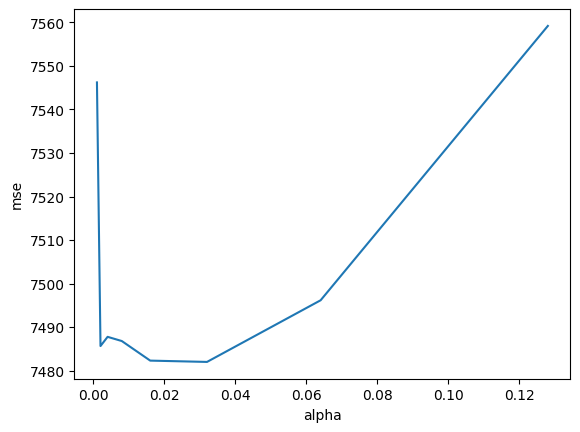

Time taken to train the model:  1.2765302658081055
Root Mean Squared Error: 8276.733410799
Best rmse for Linear Regression (scratch): 8276.733410799 with lr=0.032


In [17]:
 #TO DEL
def get_model(param):
    return  ScratchLinearRegression(regularization='', n_iters=1000,lr=param)


def iterate_hyperparameters():
    alpha = 0.001
    while alpha < 0.2:
        yield alpha
        alpha *= 2


best_param, params, accuracies = optimize_hyperparameters(get_model, iterate_hyperparameters(), train, test, val,
                                                          classification=False)
plot_2d(params, accuracies, 'alpha', 'mse')
regressor = get_model(best_param)

rmse_LR_NR_my = test_model(regressor, train, test, classification=False)
print(f"Best rmse for Linear Regression (scratch): {rmse_LR_NR_my} with lr={best_param}")


## L1 regularization

### Sklearn

In [18]:
regressor = SGDRegressor(max_iter=1000, penalty='l1', learning_rate='constant', shuffle=False, eta0=0.00001, alpha=100)
rmse_LR_L1_sk = test_model(regressor, train, test, classification=False)

Time taken to train the model:  5.528799772262573
Root Mean Squared Error: 8251.875504985122


### Scratch

Trying hyperparameters: 0.1
Time taken to train the model:  1.1920292377471924
Root Mean Squared Error: 7485.112666374343
Value: 7485.112666374343
Trying hyperparameters: 0.2
Time taken to train the model:  1.4812991619110107
Root Mean Squared Error: 7484.96648216334
Value: 7484.96648216334
Trying hyperparameters: 0.4
Time taken to train the model:  1.3945503234863281
Root Mean Squared Error: 7484.705585117933
Value: 7484.705585117933
Trying hyperparameters: 0.8
Time taken to train the model:  1.6602447032928467
Root Mean Squared Error: 7484.280579452767
Value: 7484.280579452767
Trying hyperparameters: 1.6
Time taken to train the model:  1.4146063327789307
Root Mean Squared Error: 7483.790943200983
Value: 7483.790943200983
Trying hyperparameters: 3.2
Time taken to train the model:  2.3521533012390137
Root Mean Squared Error: 7483.222028489958
Value: 7483.222028489958
Trying hyperparameters: 6.4
Time taken to train the model:  1.2931208610534668
Root Mean Squared Error: 7482.16639970295

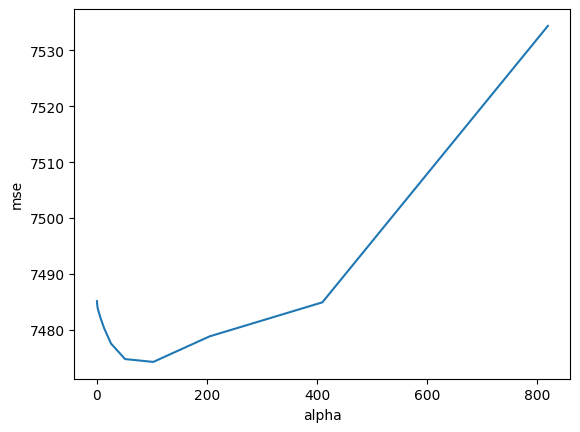

Time taken to train the model:  1.1947875022888184
Root Mean Squared Error: 8251.90777476523
Best rmse for Linear Regression L1 (scratch): 8251.90777476523 with alpha=102.4


In [19]:
def get_model(param):
    return ScratchLinearRegression(regularization='l1', alpha=param,lr=0.01)


def iterate_hyperparameters():
    # for alpha in range(1,1000,100):
    #     yield alpha
    alpha = 0.1
    while alpha < 1000:
        yield alpha
        alpha *= 2


best_param, params, accuracies = optimize_hyperparameters(get_model, iterate_hyperparameters(), train, test, val,
                                                          classification=False)
plot_2d(params, accuracies, 'alpha', 'mse')
regressor = ScratchLinearRegression(regularization='l1', alpha=best_param)

rmse_LR_L1_my = test_model(regressor, train, test, classification=False)
print(f"Best rmse for Linear Regression L1 (scratch): {rmse_LR_L1_my} with alpha={best_param}")

##  L2 regularization

### Sklearn

In [20]:
regressor = SGDRegressor(max_iter=1000, penalty='l2', learning_rate='constant', shuffle=False, eta0=0.00001, alpha=0.5)
rmse_LR_L2_sk = test_model(regressor, train, test, classification=False)

Time taken to train the model:  0.4554002285003662
Root Mean Squared Error: 8266.18668587692


### Scratch

Trying hyperparameters: 0.001
Time taken to train the model:  1.4053966999053955
Root Mean Squared Error: 7484.88229219937
Value: 7484.88229219937
Trying hyperparameters: 0.002
Time taken to train the model:  1.4223442077636719
Root Mean Squared Error: 7484.502882453825
Value: 7484.502882453825
Trying hyperparameters: 0.004
Time taken to train the model:  1.309758186340332
Root Mean Squared Error: 7483.7728705543095
Value: 7483.7728705543095
Trying hyperparameters: 0.008
Time taken to train the model:  1.3877246379852295
Root Mean Squared Error: 7482.4243387325205
Value: 7482.4243387325205
Trying hyperparameters: 0.016
Time taken to train the model:  1.3347344398498535
Root Mean Squared Error: 7480.145248096583
Value: 7480.145248096583
Trying hyperparameters: 0.032
Time taken to train the model:  1.5141808986663818
Root Mean Squared Error: 7477.061750689474
Value: 7477.061750689474
Trying hyperparameters: 0.064
Time taken to train the model:  1.2696526050567627
Root Mean Squared Error:

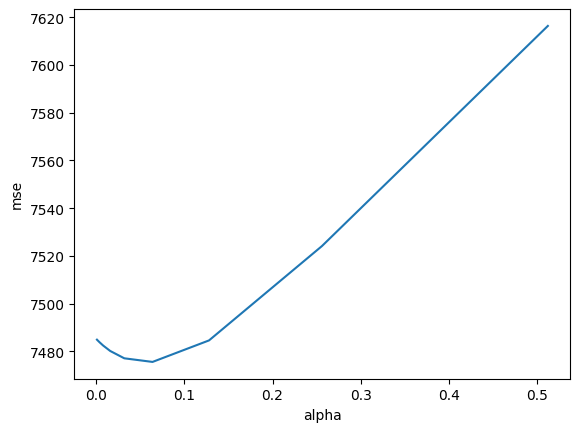

Time taken to train the model:  1.766052007675171
Root Mean Squared Error: 8270.084734322667
Best rmse for Linear Regression L2 (scratch): 8251.90777476523 with alpha=0.064


In [21]:
#L2 regularization
def get_model(param):
    return ScratchLinearRegression(regularization='l2', alpha=param,lr=0.01)

def iterate_hyperparameters():
    alpha = 0.001
    while alpha < 1:
        yield alpha
        alpha *= 2


best_param, params, accuracies = optimize_hyperparameters(get_model, iterate_hyperparameters(), train, test, val,
                                                          classification=False)
plot_2d(params, accuracies, 'alpha', 'mse')
regressor = ScratchLinearRegression(regularization='l2', alpha=best_param)

rmse_LR_L2_my = test_model(regressor, train, test, classification=False)
print(f"Best rmse for Linear Regression L2 (scratch): {rmse_LR_L1_my} with alpha={best_param}")

## Elastic net regularization

### Sklearn

In [22]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=0.01, l1_ratio=0.2)
rmse_LR_EL_sk = test_model(model, train, test, classification=False)

Time taken to train the model:  2.257662296295166
Root Mean Squared Error: 8274.942072408272


In [23]:
model = SGDRegressor(max_iter=1000, penalty='elasticnet', learning_rate='constant', shuffle=False, eta0=0.00001,
                     early_stopping=False, alpha=0.5, l1_ratio=0.5)
rmse_LR_EL_sk = test_model(model, train, test, classification=False)

Time taken to train the model:  1.8874337673187256
Root Mean Squared Error: 8269.28193026024


### Scratch

In [ ]:
def get_model(param):
    return ScratchLinearRegression(regularization='elasticnet', alpha=param)


def iterate_hyperparameters():
    l1 = 1
    while l1 < 200:
        l2 = 0.001
        while l2 < 0.5:
            yield l1 / (l1 + l2)
            l2 *= 2
        l1 *= 2


best_param, params, accuracies = optimize_hyperparameters(get_model, iterate_hyperparameters(), train, test, val,
                                                          classification=False)
plot_2d(params, accuracies, 'alpha', 'mse')
regressor = ScratchLinearRegression(regularization='elasticnet', alpha=best_param)

rmse_LR_EL_my = test_model(regressor, train, test, classification=False)

Trying hyperparameters: 0.91
Time taken to train the model:  1.2385883331298828
Root Mean Squared Error: 7476.958864682971
Value: 7476.958864682971
Trying hyperparameters: 0.92
Time taken to train the model:  1.2972238063812256
Root Mean Squared Error: 7475.779325010018
Value: 7475.779325010018
Trying hyperparameters: 0.93
Time taken to train the model:  1.3651149272918701
Root Mean Squared Error: 7474.958699203574
Value: 7474.958699203574
Trying hyperparameters: 0.9400000000000001
Time taken to train the model:  1.363832712173462
Root Mean Squared Error: 7474.5326165085735
Value: 7474.5326165085735
Trying hyperparameters: 0.9500000000000001
Time taken to train the model:  1.2779676914215088
Root Mean Squared Error: 7474.556807375743
Value: 7474.556807375743
Trying hyperparameters: 0.96
Time taken to train the model:  1.3523650169372559
Root Mean Squared Error: 7475.114419448678
Value: 7475.114419448678
Trying hyperparameters: 0.97
Time taken to train the model:  1.296647071838379
Root

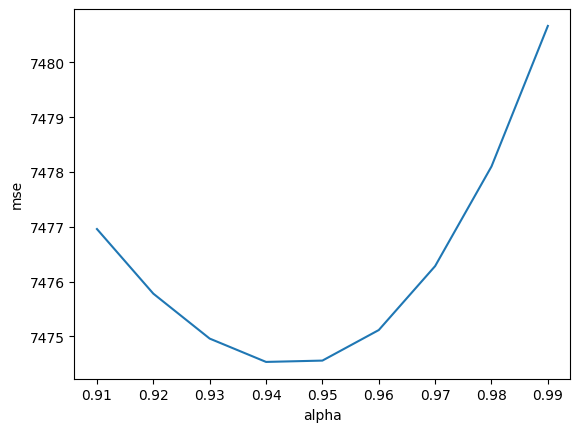

Time taken to train the model:  1.313507318496704
Root Mean Squared Error: 8269.685809161045


In [25]:
#Elastic net regularization

def get_model(param):
    return ScratchLinearRegression(regularization='elasticnet', alpha=param)


def iterate_hyperparameters():
    # for alpha in range(1,1000,100): #giuliu dice esponenziale tra 0 e 1
    #     yield alpha

    for a in range(1, 10):
        yield 0.9 + a / 100


best_param, params, accuracies = optimize_hyperparameters(get_model, iterate_hyperparameters(), train, test, val,
                                                          classification=False)
plot_2d(params, accuracies, 'alpha', 'mse')
regressor = ScratchLinearRegression(regularization='elasticnet', alpha=best_param)

rmse_LR_EL_my = test_model(regressor, train, test, classification=False)

Trying hyperparameters: (0.01, 0.5)
Time taken to train the model:  1.2728962898254395
Root Mean Squared Error: 7483.414103018966
Value: 7483.414103018966
Trying hyperparameters: (0.01, 0.6)
Time taken to train the model:  1.327404260635376
Root Mean Squared Error: 7483.763359048399
Value: 7483.763359048399
Trying hyperparameters: (0.01, 0.7)
Time taken to train the model:  1.4444658756256104
Root Mean Squared Error: 7484.1219701469745
Value: 7484.1219701469745
Trying hyperparameters: (0.01, 0.8)
Time taken to train the model:  1.2121357917785645
Root Mean Squared Error: 7484.490071453804
Value: 7484.490071453804
Trying hyperparameters: (0.01, 0.9)
Time taken to train the model:  1.152111530303955
Root Mean Squared Error: 7484.867799914208
Value: 7484.867799914208
Trying hyperparameters: (0.02, 0.5)
Time taken to train the model:  1.0796518325805664
Root Mean Squared Error: 7481.788458210888
Value: 7481.788458210888
Trying hyperparameters: (0.02, 0.6)
Time taken to train the model:  1.

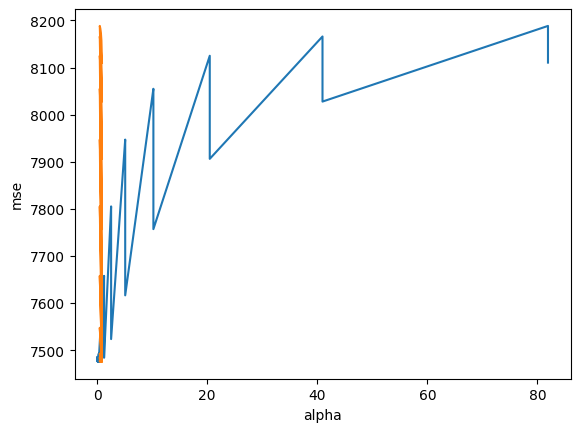

Time taken to train the model:  10.554092645645142
Root Mean Squared Error: 8269.833693498433


In [26]:
#Elastic net regularization

def get_model(param):
    a, b = param
    return ScratchLinearRegression(regularization='elasticnetV2', alpha=a, l1_ratio=b)


def iterate_hyperparameters():
    # for alpha in range(1,1000,100): #giuliu dice esponenziale tra 0 e 1
    #     yield alpha

    a = 0.01
    while a < 100:
        for b in range(5, 10):
            yield a, b / 10
        a *= 2


best_param, params, accuracies = optimize_hyperparameters(get_model, iterate_hyperparameters(), train, test, val,
                                                          classification=False)
plot_2d(params, accuracies, 'alpha', 'mse')
a, b = best_param
regressor = ScratchLinearRegression(regularization='elasticnetV2', alpha=a, l1_ratio=b)

rmse_LR_EL_my = test_model(regressor, train, test, classification=False)

In [27]:
from utils import *

# Linear Classification
The Class for linear and logistic classification is the same one as the one for linear regression

In [71]:
df, train, test, val = get_data(normalize=True, binary_label=True)

In [3]:
from sklearn.linear_model import SGDClassifier

In [4]:
def _sigmoid(x):
    return 1 / (1 + np.exp(-x))


class ScratchLinearRegression:

    def __init__(self, lr=0.01, n_iters=1000, regularization=None, alpha=0.1, l1_ratio=0.5, logistic=False,
                 classification=True):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.regularization = regularization
        self.regularization_param = alpha
        self.l1_ratio = l1_ratio
        self.classification = classification
        self.model = 'logistic' if logistic else 'perceptron'  #todo check

    def fit(self, X, y):
        n_samples, n_features = X.shape

        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            y_pred = np.dot(X, self.weights) + self.bias

            if self.classification:
                if self.model == 'logistic':
                    y_pred = _sigmoid(y_pred)
                else:
                    y_pred = np.where(y_pred >= 0, 1, 0)
            if self.regularization == 'l1':
                dw = (1 / n_samples) * np.dot(X.T, (y_pred - y)) + np.sign(self.weights) * self.regularization_param
                db = (1 / n_samples) * np.sum(y_pred - y) + np.sign(self.bias) * self.regularization_param

            elif self.regularization == 'l2':
                dw = (1 / n_samples) * np.dot(X.T, (y_pred - y)) + 2 * self.weights * self.regularization_param
                db = (1 / n_samples) * np.sum(y_pred - y) + 2 * self.bias * self.regularization_param
            elif self.regularization == 'elasticnet':
                dw = ((1 / n_samples) * np.dot(X.T, (y_pred - y))
                      + 2 * self.weights * (1 - self.regularization_param)
                      + np.sign(self.weights) * self.regularization_param)
                db = ((1 / n_samples) * np.sum(y_pred - y)
                      + 2 * self.bias * (1 - self.regularization_param)
                      + np.sign(self.bias) * self.regularization_param)
            elif self.regularization == 'elasticnetV2':
                dw = (
                        (1 / n_samples) * np.dot(X.T, (y_pred - y))
                        + self.regularization_param *
                        (
                                2 * self.weights * (1 - self.l1_ratio)
                                + np.sign(self.weights) * self.l1_ratio
                        )
                )
                db = (
                        (1 / n_samples) * np.sum(y_pred - y)
                        + self.regularization_param *
                        (
                                2 * self.bias * (1 - self.l1_ratio)
                                + np.sign(self.bias) * self.l1_ratio
                        )
                )
            elif self.regularization is None or self.regularization == '':
                dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
                db = (1 / n_samples) * np.sum(y_pred - y)
            else:
                raise ValueError('Invalid regularization parameter')

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        y_pred = np.dot(X, self.weights) + self.bias

        if self.classification:
            if self.model == 'logistic':
                y_pred = _sigmoid(y_pred)
                y_pred = [1 if i >= 0.5 else 0 for i in y_pred]
            else:
                y_pred = [1 if i >= 0 else 0 for i in y_pred]
        return y_pred

## No regularization

### Sklearn

In [72]:
regressor = SGDClassifier(max_iter=1000, penalty=None, learning_rate='constant', shuffle=False, eta0=0.001,
                          early_stopping=False, loss='perceptron')
accuracy_LC_NR_sk = test_model(regressor, train, test, classification=True)

Time taken to train the model:  0.01730060577392578
Accuracy: 0.5426913860512045


### Scratch

In [73]:
#No regularization
regressor = ScratchLinearRegression(regularization='', classification=True)
accuracy_LC_NR_my = test_model(regressor, train, test, classification=True)

Time taken to train the model:  1.58327317237854
Accuracy: 0.5816622524908563


## L1 Regularization

L1 Regularization does not benefit the model

Trying hyperparameters: 0
Time taken to train the model:  4.000712633132935
Accuracy: 0.5949865994009144
Value: 0.5949865994009144
Trying hyperparameters: 1e-05
Time taken to train the model:  3.3943796157836914
Accuracy: 0.5949865994009144
Value: 0.5949865994009144
Trying hyperparameters: 0.0005
Time taken to train the model:  1.5874755382537842
Accuracy: 0.59325240422513
Value: 0.59325240422513
Trying hyperparameters: 0.001
Time taken to train the model:  1.6109647750854492
Accuracy: 0.5927794419044616
Value: 0.5927794419044616
Trying hyperparameters: 0.01
Time taken to train the model:  1.5883352756500244
Accuracy: 0.5798518051395238
Value: 0.5798518051395238
Trying hyperparameters: 0.1
Time taken to train the model:  1.6685774326324463
Accuracy: 0.49787166955699197
Value: 0.49787166955699197
Best hyperparameters: 0
Best value: 0.5949865994009144


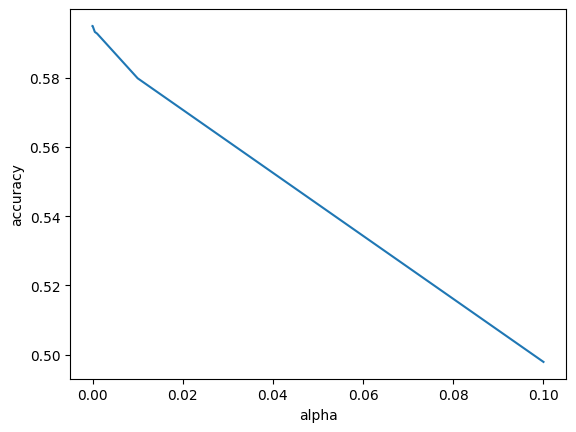

Time taken to train the model:  1.5679666996002197
Accuracy: 0.5816622524908563
Best rmse for Linear Classification L1 (scratch): 0.5816622524908563 with alpha=0


In [74]:
def get_model(param):
    return ScratchLinearRegression(regularization='l1', alpha=param, classification=True)

best_param, params, accuracies = optimize_hyperparameters(get_model, (0,0.00001,0.0005,0.001,0.01), train, test, val,
                                                          classification=True)
plot_2d(params, accuracies, 'alpha', 'mse')
regressor = ScratchLinearRegression(regularization='l1', alpha=best_param, classification=True)

accuracy_LC_L1_my = test_model(regressor, train, test, classification=True)
print(f"Best rmse for Linear Classification L1 (scratch): {accuracy_LC_L1_my} with alpha={best_param}")


## L2

Trying hyperparameters: 0
Time taken to train the model:  4.26898193359375
Accuracy: 0.5949865994009144
Value: 0.5949865994009144
Trying hyperparameters: 1e-05
Time taken to train the model:  8.024325847625732
Accuracy: 0.5951442535078039
Value: 0.5951442535078039
Trying hyperparameters: 0.0005
Time taken to train the model:  2.983619213104248
Accuracy: 0.5946712911871355
Value: 0.5946712911871355
Trying hyperparameters: 0.001
Time taken to train the model:  1.7517600059509277
Accuracy: 0.5946712911871355
Value: 0.5946712911871355
Trying hyperparameters: 0.01
Time taken to train the model:  1.7607710361480713
Accuracy: 0.5948289452940249
Value: 0.5948289452940249
Trying hyperparameters: 0.1
Time taken to train the model:  1.9996225833892822
Accuracy: 0.5908875926217878
Value: 0.5908875926217878
Best hyperparameters: 1e-05
Best value: 0.5951442535078039


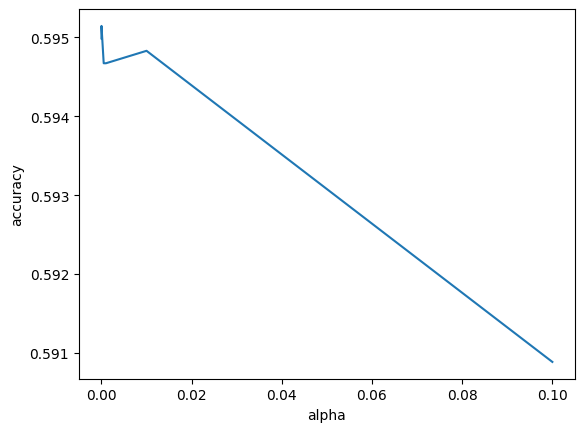

Time taken to train the model:  6.81121301651001
Accuracy: 0.5817883717997225
Best accuracy for Linear Regression L2 (scratch): 0.5817883717997225 with alpha=1e-05


In [75]:
#L2 regularization

def get_model(param):
    return ScratchLinearRegression(regularization='l2', alpha=param, classification=True,lr=0.1)


def iterate_hyperparameters():
    alpha = 0.00001
    while alpha < 1:
        yield alpha
        alpha *=10


best_param, params, accuracies = optimize_hyperparameters(get_model, (0,0.00001,0.0005,0.001,0.01), train, test, val,
                                                          classification=True)
plot_2d(params, accuracies, 'alpha', 'accuracy')
regressor = ScratchLinearRegression(regularization='l2', alpha=best_param, classification=True)

accuracy_LC_L2_my = test_model(regressor, train, test, classification=True)
print(f"Best accuracy for Linear Regression L2 (scratch): {accuracy_LC_L2_my} with alpha={best_param}")

L1 and L2 regularization does not benefit the model therefore is useless to test elasticnet

# Logistic Classifier

## No Regularization

### Sklearn

In [76]:
from sklearn.linear_model import LogisticRegression

regressor = LogisticRegression(max_iter=1000, penalty=None)
accuracy_LO_NR_sk=test_model(regressor, train, test, classification=True)

Time taken to train the model:  1.2148427963256836
Accuracy: 0.6483793668810695


In [36]:
regressor = SGDClassifier(max_iter=1000, penalty=None, learning_rate='constant', shuffle=False, eta0=0.0005,
                          early_stopping=False, loss='log_loss')
accuracy_LO_NR_sk=test_model(regressor, train, test, classification=True)


Time taken to train the model:  2.6818342208862305
Accuracy: 0.6501450372051961


### Scratch

In [77]:
#No regularization
regressor = ScratchLinearRegression(regularization='', logistic=True, classification=True,lr=0.9)
accuracy_LO_NR_my = test_model(regressor, train, test, classification=True)

Time taken to train the model:  7.325318813323975
Accuracy: 0.6501450372051961


Trying hyperparameters: 0.1
Time taken to train the model:  2.0857906341552734
Accuracy: 0.6582058962635977
Value: 0.6582058962635977
Trying hyperparameters: 0.2
Time taken to train the model:  1.965118408203125
Accuracy: 0.660886016080719
Value: 0.660886016080719
Trying hyperparameters: 0.30000000000000004
Time taken to train the model:  2.23722767829895
Accuracy: 0.6618319407220558
Value: 0.6618319407220558
Trying hyperparameters: 0.4
Time taken to train the model:  3.651921510696411
Accuracy: 0.6634084817909507
Value: 0.6634084817909507
Trying hyperparameters: 0.5
Time taken to train the model:  5.360713005065918
Accuracy: 0.6627778653633927
Value: 0.6627778653633927
Trying hyperparameters: 0.6
Time taken to train the model:  1.9107301235198975
Accuracy: 0.6627778653633927
Value: 0.6627778653633927
Trying hyperparameters: 0.7
Time taken to train the model:  2.0326075553894043
Accuracy: 0.6627778653633927
Value: 0.6627778653633927
Trying hyperparameters: 0.7999999999999999
Time taken

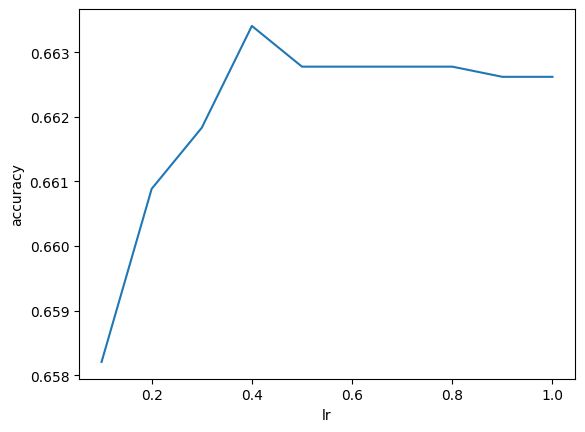

Time taken to train the model:  1.8588192462921143
Accuracy: 0.6495144406608652
Best accuracy for Logistic Classification (scratch): 0.6495144406608652 with lr=0.4


In [78]:
def get_model(param):
    return  ScratchLinearRegression(regularization='', logistic=True, classification=True,lr=param)


def iterate_hyperparameters():
    alpha = 0.1
    while alpha < 1:
        yield alpha
        alpha += 0.1


best_lr, params, accuracies = optimize_hyperparameters(get_model, iterate_hyperparameters(), train, test, val,
                                                          classification=True)
plot_2d(params, accuracies, 'lr', 'accuracy')
best_model = get_model(best_lr)

accuracy_LO_NR_my = test_model(best_model, train, test, classification=True)
print(f"Best accuracy for Logistic Classification (scratch): {accuracy_LO_NR_my} with lr={best_lr}")

## L1 Regularization

Trying hyperparameters: 0
Time taken to train the model:  1.9367907047271729
Binary cross entropy: 12.160400165964166
Accuracy: 0.6626202112565033
Value: 0.6626202112565033
Trying hyperparameters: 1e-05
Time taken to train the model:  1.686460256576538
Binary cross entropy: 12.160400165964166
Accuracy: 0.6626202112565033
Value: 0.6626202112565033
Trying hyperparameters: 0.0001
Time taken to train the model:  1.5976974964141846
Binary cross entropy: 12.188812315884642
Accuracy: 0.6618319407220558
Value: 0.6618319407220558
Trying hyperparameters: 0.001
Time taken to train the model:  1.7854092121124268
Binary cross entropy: 12.274048765646073
Accuracy: 0.6594671291187135
Value: 0.6594671291187135
Trying hyperparameters: 0.01
Time taken to train the model:  1.6837406158447266
Binary cross entropy: 12.393379795312077
Accuracy: 0.6561563928740344
Value: 0.6561563928740344
Best hyperparameters: 0
Best value: 0.6626202112565033


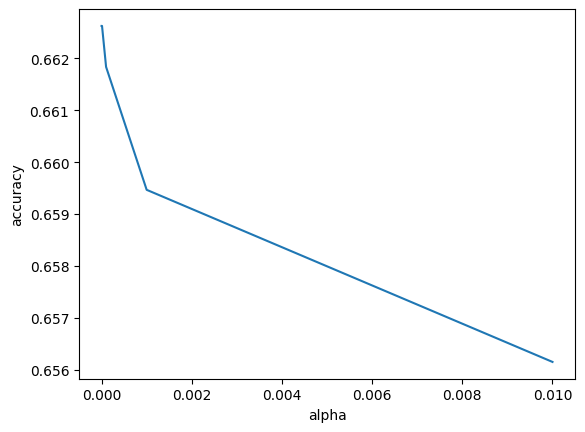

Time taken to train the model:  1.5569877624511719
Binary cross entropy: 12.610051015438387
Accuracy: 0.6501450372051961


0.6501450372051961

In [77]:
if not best_lr:
    best_lr = 0.9

def get_model(param):
    return ScratchLinearRegression(regularization='l1', alpha=param, classification=True, logistic=True,lr=best_lr)

best_param, params, accuracies = optimize_hyperparameters(get_model, (0,0.00001,0.0001,0.001,0.01), train, test, val,
                                                          classification=True)
plot_2d(params, accuracies, 'alpha', 'accuracy')
best_model = get_model(best_param)

test_model(best_model, train, test, classification=True)

Trying hyperparameters: 0
Time taken to train the model:  2.1695077419281006
Accuracy: 0.6634084817909507
Value: 0.6634084817909507
Trying hyperparameters: 1e-05
Time taken to train the model:  1.8361566066741943
Accuracy: 0.6634084817909507
Value: 0.6634084817909507
Trying hyperparameters: 0.0001
Time taken to train the model:  5.3780786991119385
Accuracy: 0.6623049030427243
Value: 0.6623049030427243
Trying hyperparameters: 0.001
Time taken to train the model:  4.708841323852539
Accuracy: 0.6597824373324925
Value: 0.6597824373324925
Trying hyperparameters: 0.01
Time taken to train the model:  7.547176361083984
Accuracy: 0.6548951600189185
Value: 0.6548951600189185
Best hyperparameters: 0
Best value: 0.6634084817909507


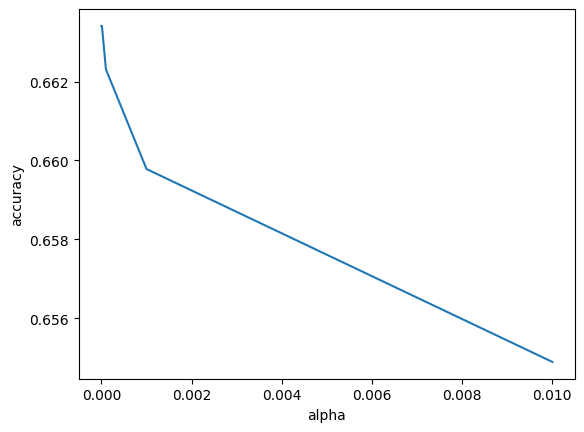

Time taken to train the model:  1.889350175857544
Accuracy: 0.6495144406608652
Best accuracy for Logistic Classification L1 (scratch): 0.6495144406608652 with lr=0.4


In [79]:
#L2 regularization

def get_model(param):
    return ScratchLinearRegression(regularization='l2', alpha=param, classification=True, logistic=True)


def iterate_hyperparameters():
    alpha = 0.001
    while alpha < 1:
        yield alpha
        alpha *= 2


best_param, params, accuracies = optimize_hyperparameters(get_model, (0,0.00001,0.0001,0.001,0.01,0.1,0.5), train, test, val,
                                                          classification=True)
plot_2d(params, accuracies, 'alpha', 'accuracy')
best_model = get_model(best_param)

accuracy_LO_L2_my=test_model(best_model, train, test, classification=True)
print(f"Best accuracy for Logistic Classification L2 (scratch): {accuracy_LO_L2_my} with lr={best_param}")

Trying hyperparameters: 0
Time taken to train the model:  2.024383544921875
Accuracy: 0.6484313416364497
Value: 0.6484313416364497
Trying hyperparameters: 1e-05
Time taken to train the model:  1.6346325874328613
Accuracy: 0.6484313416364497
Value: 0.6484313416364497
Trying hyperparameters: 0.0001
Time taken to train the model:  2.0765674114227295
Accuracy: 0.6484313416364497
Value: 0.6484313416364497
Trying hyperparameters: 0.001
Time taken to train the model:  1.715477705001831
Accuracy: 0.6485889957433392
Value: 0.6485889957433392
Trying hyperparameters: 0.01
Time taken to train the model:  1.7259624004364014
Accuracy: 0.6492196121708971
Value: 0.6492196121708971
Trying hyperparameters: 0.1
Time taken to train the model:  1.6447429656982422
Accuracy: 0.6478007252088916
Value: 0.6478007252088916
Trying hyperparameters: 0.5
Time taken to train the model:  1.634770154953003
Accuracy: 0.644647643071102
Value: 0.644647643071102
Best hyperparameters: 0.01
Best value: 0.6492196121708971


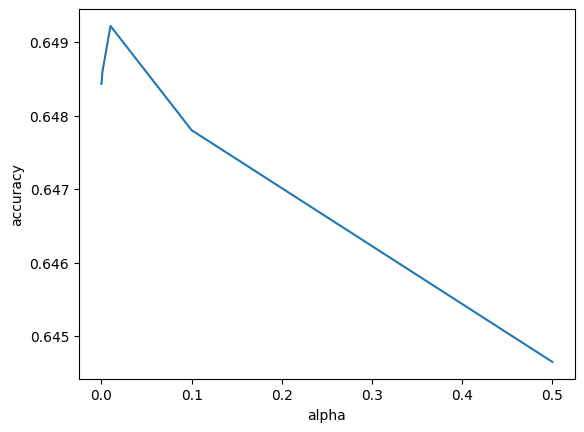

Time taken to train the model:  1.5584914684295654
Accuracy: 0.6448480262328162
Best accuracy for Logistic Classification L2 (scratch): 0.6448480262328162 with lr=0.01


In [41]:
from utils import *

# KNN
Since hyperparameter optimization would be extremely slow with the non-optimized version of KNN the parameters will be chosen using the sklearn implementation and then tested on the one from scratch.
For the classification normalized data will be used, on the contrary for regression the data will not be normalized.

In [42]:
from scipy.spatial.distance import cdist


class ScratchKNeighbors:
    def __init__(self, classification, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None
        self.classification = classification

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        distances = cdist(X_test, self.X_train) # euclidean distances
        nearest_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors] # indices of n nearest neighbors
        nearest_targets = self.y_train[nearest_indices]
        predictions = np.mean(nearest_targets, axis=1)
        if self.classification:  #Majority vote is useless if binary classification
            return predictions >= 0.5
        return predictions

Time taken to train the model:  0.0025086402893066406
Accuracy: 0.6072644721906924


0.6072644721906924

## Classification

In [47]:
df, train, test, val = get_data(normalize=True, binary_label=True)  # Normalizing the data leads to a slightly better accuracy (58% vs 63% for sklearn, 59% vs 64% for scratch)

### Sklearn

In [49]:
from sklearn.neighbors import KNeighborsClassifier

regressor = KNeighborsClassifier(n_neighbors=5)

test_model(regressor, train, test, classification=True)

Time taken to train the model:  0.0021734237670898438
Binary cross entropy: 13.182821897898819
Accuracy: 0.6342540042880564


0.6342540042880564

In [45]:
def get_model(param):
    return KNeighborsClassifier(n_neighbors=param)


best_param, params, accuracies = optimize_hyperparameters(get_model, range(1, 100, 5), train, test, val,
                                                          classification=True)
plot_2d(params, accuracies, 'k', 'accuracy')
best_model = get_model(best_param)

accuracy_KNN_sk = test_model(best_model, train, test, classification=True)
print(f"Best accuracy for KNN (sklearn): {accuracy_KNN_sk} with k={best_param}")

### Scratch

In [46]:
regressor = ScratchKNeighbors(classification=True, n_neighbors=30)
accuracy_KNN_my = test_model(regressor, train, test, classification=True)

Time taken to train the model:  0.001392364501953125
Root Mean Squared Error: 9314.63167163207


9314.63167163207

## Regression

In [59]:
df, train, test, val = get_data(normalize=False, binary_label=False) # Normalizing the data leads to slightly worse loss (8582 vs 8505)

### Sklearn

In [58]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=5)

test_model(regressor, train, test, classification=False)

Time taken to train the model:  0.00323486328125
Root Mean Squared Error: 9325.832134734226


9325.832134734226

In [49]:
def get_model(param):
    return KNeighborsRegressor(n_neighbors=param)


best_param, params, accuracies = optimize_hyperparameters(get_model, range(1, 100, 5), train, test, val,
                                                          classification=False)
plot_2d(params, accuracies, 'k', 'mse')
best_model = get_model(best_param)

rmse_KNN_sk = test_model(regressor, train, test, classification=False)
print(f"Best rmse for KNN (sklearn): {rmse_KNN_sk} with k={best_param}")


After k ~ 30 there is a clear diminishing return on loss reduction, therefore this k will be used

In [50]:
regressor = ScratchKNeighbors(classification=False, n_neighbors=30)
rmse_KNN_my = test_model(regressor, train, test, classification=False)

In [1]:
from utils import *

# Neural Network

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(x):
    return x * (1 - x)


def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)


class ScratchNeuralNetwork:

    def __init__(self, input_dim, hidden_dim, learning_rate=0.01, classification=False, epochs=10):
        self.W1 = np.random.rand(input_dim, hidden_dim)
        self.W2 = np.random.rand(hidden_dim, 1)
        self.b1 = np.zeros((1, hidden_dim))
        self.b2 = np.zeros((1, 1))
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.hidden_dim = hidden_dim
        self.classification = classification
        self.activation = sigmoid if classification else relu
        self.activation_derivative = sigmoid_derivative if classification else relu_derivative
        self.hidden_output = None

    def forward(self, X):
        self.hidden_output = self.activation(np.dot(X, self.W1) + self.b1)
        output = np.dot(self.hidden_output, self.W2) + self.b2
        return self.activation(output)

    def backward(self, X, y, output):
        error = (output - y)
        error /= X.shape[0]  # divide by batch size
        if not self.classification:  # For classification the activation derivative is simplified with the log_loss
            error = error * self.activation_derivative(output)
        d_weights2 = np.dot(self.hidden_output.T, error)
        d_bias2 = np.sum(error, axis=0, keepdims=True)

        d_hidden_output = np.dot(error, self.W2.T) * self.activation_derivative(self.hidden_output)
        d_weights1 = np.dot(X.T, d_hidden_output)
        d_bias1 = np.sum(d_hidden_output, axis=0, keepdims=True)

        lr = self.learning_rate

        self.W2 -= lr * d_weights2
        self.b2 -= lr * d_bias2
        self.W1 -= lr * d_weights1
        self.b1 -= lr * d_bias1

    def fit(self, X, y):
        y = y.reshape(-1, 1)
        for i in range(self.epochs):
            output = self.forward(X)
            self.backward(X, y, output)
            loss = np.mean(np.square(output - y))
            print("Epoch ", i, " loss: ", loss)

    def predict(self, X):
        y_pred = self.forward(X)
        if self.classification:
            return np.where(y_pred > 0.5, 1, 0)
        else:
            return y_pred

## Regression

In [3]:
df, train, test, val = get_data(normalize=True, binary_label=False)

### sklearn

Trying hyperparameters: 0.01
Epoch  0  loss:  186064051.05213004
Epoch  1  loss:  186049033.024327
Epoch  2  loss:  186033994.2689243
Epoch  3  loss:  186018936.48409873
Epoch  4  loss:  186003858.92372537
Epoch  5  loss:  185988760.85195187
Epoch  6  loss:  185973641.78147313
Epoch  7  loss:  185958500.95313454
Epoch  8  loss:  185943337.6489386
Epoch  9  loss:  185928151.4890752
Epoch  10  loss:  185912941.9388322
Epoch  11  loss:  185897708.27958566
Epoch  12  loss:  185882450.09165075
Epoch  13  loss:  185867167.00253782
Epoch  14  loss:  185851858.30353612
Epoch  15  loss:  185836523.4171093
Epoch  16  loss:  185821161.8951344
Epoch  17  loss:  185805773.1748943
Epoch  18  loss:  185790356.75625113
Epoch  19  loss:  185774912.19602656
Epoch  20  loss:  185759438.87957066
Epoch  21  loss:  185743936.29371005
Epoch  22  loss:  185728403.73965067
Epoch  23  loss:  185712840.5281405
Epoch  24  loss:  185697245.79532403
Epoch  25  loss:  185681619.40611902
Epoch  26  loss:  185665961.1

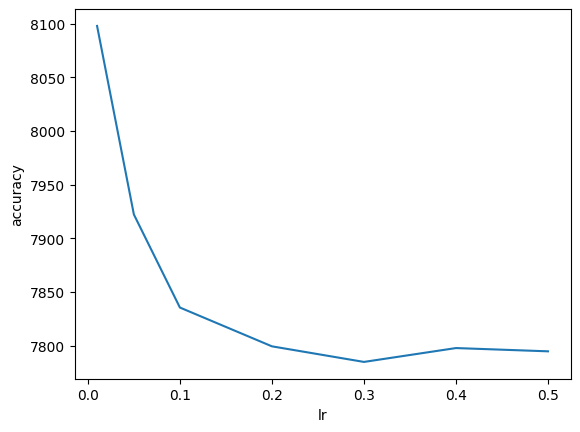

Epoch  0  loss:  186117621.32099396
Epoch  1  loss:  185662767.7055915
Epoch  2  loss:  185186656.0609889
Epoch  3  loss:  184676705.55467945
Epoch  4  loss:  184126014.38368
Epoch  5  loss:  183533714.82904556
Epoch  6  loss:  182905565.11039105
Epoch  7  loss:  182253601.94249925
Epoch  8  loss:  181595256.53894553
Epoch  9  loss:  180950371.42848155
Epoch  10  loss:  180338806.4592933
Epoch  11  loss:  179775001.73945072
Epoch  12  loss:  179267987.5886825
Epoch  13  loss:  178819211.7984799
Epoch  14  loss:  178424457.40228778
Epoch  15  loss:  178076220.41129982
Epoch  16  loss:  177765615.56939447
Epoch  17  loss:  177483659.18035245
Epoch  18  loss:  177223696.30308926
Epoch  19  loss:  176980056.82086048
Epoch  20  loss:  176748840.97837397
Epoch  21  loss:  176527122.83057672
Epoch  22  loss:  176312523.6070345
Epoch  23  loss:  176103796.17801276
Epoch  24  loss:  175899793.22137746
Epoch  25  loss:  175700476.79984176
Epoch  26  loss:  175505451.50353643
Epoch  27  loss:  17

In [54]:
from sklearn.neural_network import MLPRegressor

regressor = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='relu',
    # solver='sgd',
    alpha=0.0000,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    shuffle=True,
    random_state=1,
    verbose=True,
    # momentum=0.3
    max_iter=100,
)
rmse_NN_sk = test_model(regressor, train, test, classification=False)

### scratch

In [55]:
df, train, test, val = get_data(normalize=True, binary_label=False)
my_regressor = ScratchNeuralNetwork(input_dim=58, hidden_dim=100, learning_rate=0.00001, epochs=100,
                                    classification=False)
rmse_NN_my = test_model(my_regressor, train, test, classification=False)

Given that the optimization is quite expensive hidden_dim and lr will be optimized separately

In [56]:
def get_model(param):
    return ScratchNeuralNetwork(input_dim=58, hidden_dim=param, learning_rate=0.00001, epochs=100,
                                classification=False)


best_h, params, accuracies = optimize_hyperparameters(get_model, range(100, 1000, 200), train, test, val,
                                                      classification=False)
plot_2d(params, accuracies, 'hidden_dim', 'accuracy')
best_model = get_model(param=best_h)

Time taken to train the model:  27.4086811542511
Accuracy: 0.6509017530583933


/home/vmcvastry/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [98]:
if not best_h:
    best_h = 300


def get_model(param):
    return ScratchNeuralNetwork(input_dim=58, hidden_dim=best_h, learning_rate=param * 10 ** -4, epochs=100,
                                classification=False)


best_param, params, accuracies = optimize_hyperparameters(get_model, (0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5), train, test,
                                                          val,
                                                          classification=False)
plot_2d(params, accuracies, 'lr', 'accuracy')
best_model = get_model(param=best_param)

rmse_NN_my = test_model(best_model, train, test, classification=False)

## Classification

In [6]:
df, train, test, val = get_data(normalize=True, binary_label=True)

### sklearn

Trying hyperparameters: 0.01
Epoch  0  loss:  0.45756668620050955
Epoch  1  loss:  0.45754371831493296
Epoch  2  loss:  0.4575206253524624
Epoch  3  loss:  0.4574974050651845
Epoch  4  loss:  0.45747405516131884
Epoch  5  loss:  0.4574505733043606
Epoch  6  loss:  0.4574269571122028
Epoch  7  loss:  0.45740320415624103
Epoch  8  loss:  0.4573793119604575
Epoch  9  loss:  0.4573552780004857
Epoch  10  loss:  0.45733109970265434
Epoch  11  loss:  0.45730677444301043
Epoch  12  loss:  0.457282299546321
Epoch  13  loss:  0.4572576722850522
Epoch  14  loss:  0.457232889878327
Epoch  15  loss:  0.45720794949085874
Epoch  16  loss:  0.45718284823186195
Epoch  17  loss:  0.4571575831539381
Epoch  18  loss:  0.45713215125193746
Epoch  19  loss:  0.45710654946179485
Epoch  20  loss:  0.4570807746593399
Epoch  21  loss:  0.4570548236590807
Epoch  22  loss:  0.4570286932129592
Epoch  23  loss:  0.4570023800090802
Epoch  24  loss:  0.4569758806704106
Epoch  25  loss:  0.45694919175344945
Epoch  26 

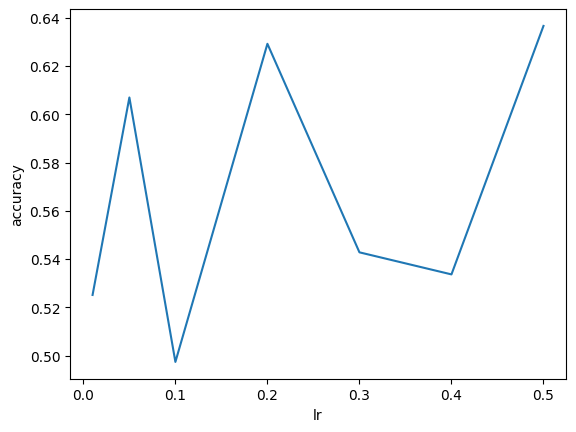

Epoch  0  loss:  0.45779739175009826
Epoch  1  loss:  0.45638576047235346
Epoch  2  loss:  0.45404905509122184
Epoch  3  loss:  0.4491739550499841
Epoch  4  loss:  0.43433449748264524
Epoch  5  loss:  0.420646357379052
Epoch  6  loss:  0.43710849081008735
Epoch  7  loss:  0.3252919420923891
Epoch  8  loss:  0.5236173165472576
Epoch  9  loss:  0.4302319362643204
Epoch  10  loss:  0.4847445970278576
Epoch  11  loss:  0.4397981476810381
Epoch  12  loss:  0.3666400282802127
Epoch  13  loss:  0.5240605870334544
Epoch  14  loss:  0.4253155609297053
Epoch  15  loss:  0.4761460675563015
Epoch  16  loss:  0.43658590132575165
Epoch  17  loss:  0.34916924802446087
Epoch  18  loss:  0.5239145485047693
Epoch  19  loss:  0.4220315849547812
Epoch  20  loss:  0.44650536825397286
Epoch  21  loss:  0.4317919732148448
Epoch  22  loss:  0.3317922878790563
Epoch  23  loss:  0.5232201110359195
Epoch  24  loss:  0.4210743381431484
Epoch  25  loss:  0.38114741537018
Epoch  26  loss:  0.41744348975063955
Epoch

In [59]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='logistic',
    learning_rate_init=0.001,
    max_iter=100,
)
accuracy_NN_sk = test_model(classifier, train, test, classification=True)

### scratch

In [67]:
my_regressor = ScratchNeuralNetwork(input_dim=58, hidden_dim=250, learning_rate=0.1, epochs=200, classification=True)
accuracy_NN_my = test_model(my_regressor, train, test, classification=True)

Epoch  0  loss:  0.45056166141658377
Epoch  1  loss:  0.44984796947303635
Epoch  2  loss:  0.4490844013451975
Epoch  3  loss:  0.4482651134548795
Epoch  4  loss:  0.4473833036835954
Epoch  5  loss:  0.4464310065469873
Epoch  6  loss:  0.4453988357995212
Epoch  7  loss:  0.44427565953025044
Epoch  8  loss:  0.44304818773300764
Epoch  9  loss:  0.44170044459285174
Epoch  10  loss:  0.4402130850742823
Epoch  11  loss:  0.4385624933487692
Epoch  12  loss:  0.43671956043196697
Epoch  13  loss:  0.4346479636023581
Epoch  14  loss:  0.4323016305266573
Epoch  15  loss:  0.42962081302463123
Epoch  16  loss:  0.42652572778429476
Epoch  17  loss:  0.42290589860215877
Epoch  18  loss:  0.4186019787309408
Epoch  19  loss:  0.4133750818117468
Epoch  20  loss:  0.40685884047239707
Epoch  21  loss:  0.39849973210262707
Epoch  22  loss:  0.38751185379717884
Epoch  23  loss:  0.37284637650780855
Epoch  24  loss:  0.35329612570660246
Epoch  25  loss:  0.3288191199312176
Epoch  26  loss:  0.30429191056181

0.6282002774624795

Given that the optimization is quite expensive hidden_dim and lr will be optimized separately

Trying hyperparameters: 100
Epoch  0  loss:  0.43946315923178947
Epoch  1  loss:  0.4368242706479235
Epoch  2  loss:  0.433836907623429
Epoch  3  loss:  0.43042468156088964
Epoch  4  loss:  0.4264818134397438
Epoch  5  loss:  0.42185645998021576
Epoch  6  loss:  0.41632436169298914
Epoch  7  loss:  0.4095497562054382
Epoch  8  loss:  0.40103199667415446
Epoch  9  loss:  0.3900339597047615
Epoch  10  loss:  0.37546256256708954
Epoch  11  loss:  0.355573544362571
Epoch  12  loss:  0.3270970804037427
Epoch  13  loss:  0.28612584913135986
Epoch  14  loss:  0.26621837721958225
Epoch  15  loss:  0.2644431828312395
Epoch  16  loss:  0.2631765000145676
Epoch  17  loss:  0.2618267777471076
Epoch  18  loss:  0.26059449524062256
Epoch  19  loss:  0.25938135607967766
Epoch  20  loss:  0.2582268162794511
Epoch  21  loss:  0.2571113790550144
Epoch  22  loss:  0.25604187500985676
Epoch  23  loss:  0.2550133679135551
Epoch  24  loss:  0.25402619070824006
Epoch  25  loss:  0.2530782501310043
Epoch  26 

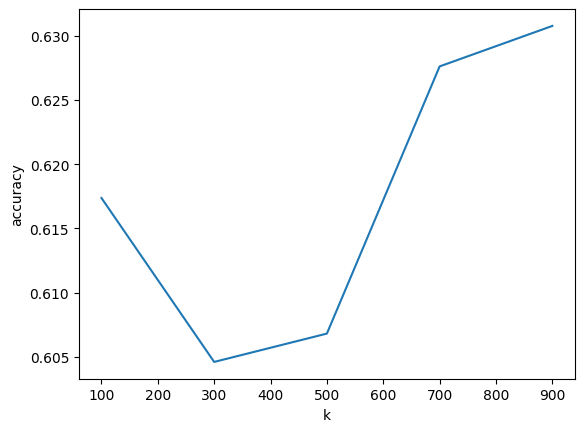

Epoch  0  loss:  0.4578349568922151
Epoch  1  loss:  0.4573587672264122
Epoch  2  loss:  0.45680949279062794
Epoch  3  loss:  0.4561543399016594
Epoch  4  loss:  0.4553444991464062
Epoch  5  loss:  0.45430615762317206
Epoch  6  loss:  0.452924695915888
Epoch  7  loss:  0.4510137613977978
Epoch  8  loss:  0.4482436301294876
Epoch  9  loss:  0.4439393544303865
Epoch  10  loss:  0.4364281441474834
Epoch  11  loss:  0.42024459616868454
Epoch  12  loss:  0.3668301404013627
Epoch  13  loss:  0.4598775711539172
Epoch  14  loss:  0.3963310173571891
Epoch  15  loss:  0.31181031365304807
Epoch  16  loss:  0.5028399964849875
Epoch  17  loss:  0.39214944372268684
Epoch  18  loss:  0.3056492316545478
Epoch  19  loss:  0.49360591253298486
Epoch  20  loss:  0.3955884282979783
Epoch  21  loss:  0.3071789443086307
Epoch  22  loss:  0.49972946887168423
Epoch  23  loss:  0.3926733365034801
Epoch  24  loss:  0.30210452086617096
Epoch  25  loss:  0.4918735800599203
Epoch  26  loss:  0.39522421393402635
Epo

0.48265859503089925

In [17]:
def get_model(param):
    return ScratchNeuralNetwork(input_dim=58, hidden_dim=param, learning_rate=0.2, epochs=100, classification=True)


best_h, params, accuracies = optimize_hyperparameters(get_model, range(100, 1000, 200), train, test, val,
                                                      classification=True)
plot_2d(params, accuracies, 'hidden_dim', 'accuracy')
best_model = get_model(param=best_h)

accuracy_NN_my = test_model(best_model, train, test, classification=True)

Trying hyperparameters: 0.01
Epoch  0  loss:  0.4350601872707736
Epoch  1  loss:  0.43491163145829836
Epoch  2  loss:  0.43476218644601194
Epoch  3  loss:  0.43461184382575163
Epoch  4  loss:  0.4344605950686487
Epoch  5  loss:  0.43430843152291393
Epoch  6  loss:  0.43415534441157405
Epoch  7  loss:  0.43400132483016096
Epoch  8  loss:  0.43384636374435087
Epoch  9  loss:  0.433690451987552
Epoch  10  loss:  0.43353358025844185
Epoch  11  loss:  0.43337573911845007
Epoch  12  loss:  0.43321691898918746
Epoch  13  loss:  0.4330571101498197
Epoch  14  loss:  0.43289630273438434
Epoch  15  loss:  0.43273448672904974
Epoch  16  loss:  0.4325716519693142
Epoch  17  loss:  0.43240778813714564
Epoch  18  loss:  0.4322428847580584
Epoch  19  loss:  0.4320769311981271
Epoch  20  loss:  0.43190991666093587
Epoch  21  loss:  0.4317418301844616
Epoch  22  loss:  0.43157266063788924
Epoch  23  loss:  0.43140239671835884
Epoch  24  loss:  0.43123102694764154
Epoch  25  loss:  0.4310585396687437
Epo

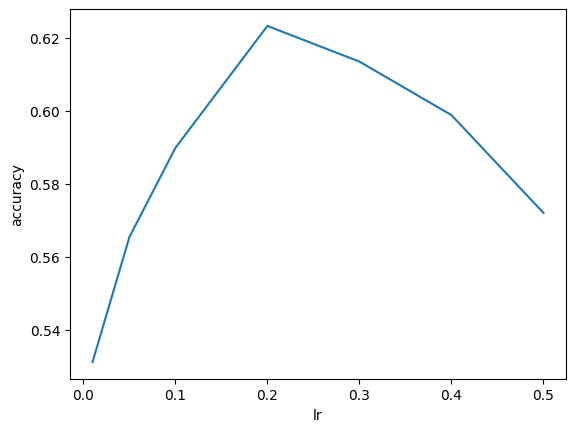

Epoch  0  loss:  0.438479717743933
Epoch  1  loss:  0.4357829749204466
Epoch  2  loss:  0.43274380115171496
Epoch  3  loss:  0.42928931013118427
Epoch  4  loss:  0.42532249775120146
Epoch  5  loss:  0.4207112650432621
Epoch  6  loss:  0.41527099556047853
Epoch  7  loss:  0.4087362581031845
Epoch  8  loss:  0.40071418016337146
Epoch  9  loss:  0.3906082550903353
Epoch  10  loss:  0.3774989854471186
Epoch  11  loss:  0.3599642643013764
Epoch  12  loss:  0.3357419789291866
Epoch  13  loss:  0.30051915571551824
Epoch  14  loss:  0.262298752128422
Epoch  15  loss:  0.25982734319083073
Epoch  16  loss:  0.2584879883329887
Epoch  17  loss:  0.25770543080169006
Epoch  18  loss:  0.2568511550947088
Epoch  19  loss:  0.2560836921861584
Epoch  20  loss:  0.2553124462602891
Epoch  21  loss:  0.2545720878233603
Epoch  22  loss:  0.25384626409767963
Epoch  23  loss:  0.2531414494903068
Epoch  24  loss:  0.252454239752651
Epoch  25  loss:  0.2517855941610434
Epoch  26  loss:  0.2511345425848607
Epoch

0.6177323748265859

In [18]:
if not best_h:
    best_h = 300


def get_model(param):
    return ScratchNeuralNetwork(input_dim=58, hidden_dim=best_h, learning_rate=param, epochs=100, classification=True)


best_param, params, accuracies = optimize_hyperparameters(get_model, (0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5), train, test,
                                                          val,
                                                          classification=True)
plot_2d(params, accuracies, 'lr', 'accuracy')
best_model = get_model(param=best_param)

accuracy_NN_my = test_model(best_model, train, test, classification=True)

#TEST

In [108]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

regressor = MLPRegressor(
    hidden_layer_sizes=(100, 100, 100),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    power_t=0.5,
    max_iter=200,
    shuffle=True,
    random_state=None,
    tol=0.0001,
    verbose=True,
    warm_start=False,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=False,
    validation_fraction=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    n_iter_no_change=10,
    max_fun=15000
)
regressor = MLPRegressor(
    hidden_layer_sizes=(400, 300, 200, 20),
    activation='logistic',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.0001,
    power_t=0.4,
    max_iter=500,
    shuffle=True,
    random_state=None,
    tol=0.0001,
    verbose=True,
    warm_start=False,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=False,
    validation_fraction=0.1,
    beta_1=0.8,
    beta_2=0.9,
    epsilon=1e-08,
    n_iter_no_change=20,
    max_fun=15000
)
test_model(regressor, train_x, train_y, test_x, test_y)


,my,sk
model,,
Linear Regression No Regularization,8281.584928,8275.739372
Linear Regression L1 Regularization,8251.907775,8251.875505
Linear Regression L2 Regularization,8270.084734,8266.186686
Linear Regression Elastic Net Regularization,8269.833693,8269.281930
KNN,8505.397209,9314.631672
NN,8285.125992,8289.592600


,my,sk
model,,
Decision Tree,0.643587,0.643713
Linear Classification No Regularization,0.581662,0.542691
Linear Classification L1 Regularization,0.581662,-
Linear Classification L2 Regularization,0.581788,0
Logistic Classification No Regularization,0.649514,0.648379
Logistic Classification L1 Regularization,0.649514,0
Logistic Classification L2 Regularization,0.644848,0
KNN,0.635894,0.635894
NN,0.632488,0.650902
